In [5]:
import os
import imutils
import easyocr
import cv2
import re
import requests
import random
import numpy as np
from matplotlib import pyplot as plt
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
from PIL import ImageFont, ImageDraw, Image

from easyocr.utils import group_text_box, get_image_list, calculate_md5, get_paragraph,\
                   download_and_unzip, printProgressBar, diff, reformat_input,\
                   make_rotated_img_list, set_result_with_confidence,\
                   reformat_input_batched, merge_to_free

In [6]:
def plt_imshow(title='image', img=None, figsize=(8,5)):
    plt.figure(figsize=figsize)
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []
 
            for i in range(len(img)):
                titles.append(title)
 
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
 
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()
        

def put_text(cv_img, text, x, y, color=(0, 0, 0), font_size=22):
    font = ImageFont.truetype('/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf', font_size)
    img = Image.fromarray(cv_img)

    draw = ImageDraw.Draw(img)
    draw.text((x, y), text, font=font, fill=color)

    cv_img = np.array(img)

    return cv_img

# 모델 조합 선택

## Opt. 1) pretrained + pretrained (korean_g1)

In [7]:
lang_list = ['ko', 'en']
model_dir = 'models'
detect_network = 'craft'
recog_network = 'korean_g1'

reader = easyocr.Reader(gpu=True,
                        lang_list=lang_list,
                        model_storage_directory=model_dir,
                        detect_network=detect_network,
                        recog_network=recog_network,
                        cudnn_benchmark=False)

## Opt. 1-1) pretrained + pretrained (korean_g2)

In [ ]:
lang_list = ['ko', 'en']
model_dir = 'models'
detect_network = 'craft'
recog_network = 'korean_g2'

reader = easyocr.Reader(gpu=True,
                        lang_list=lang_list,
                        model_storage_directory=model_dir,
                        detect_network=detect_network,
                        recog_network=recog_network,
                        cudnn_benchmark=False)

## Opt. 2) custom + custom 

In [3]:
lang_list = ['kai_ko', 'kai_en', 'kai_hj']
model_dir = 'models'
detect_network = 'craft_train_v2'
recog_network = 'kai_v1'

reader = easyocr.Reader(gpu=True,
                        lang_list=lang_list,
                        model_storage_directory=model_dir,
                        detect_network=detect_network,
                        recog_network=recog_network,
                        cudnn_benchmark=False)

len self.character: 8111
No Transformation module specified


## Opt. 3) prerained + custom

In [ ]:
lang_list = ['kai_ko', 'kai_en', 'kai_hj']
model_dir = 'models'
detect_network = 'craft'
recog_network = 'kai_v1'

reader = easyocr.Reader(gpu=True,
                        lang_list=lang_list,
                        model_storage_directory=model_dir,
                        detect_network=detect_network,
                        recog_network=recog_network,
                        cudnn_benchmark=False)

## Opt. 4) custom + pretrained (korean_g1)

In [ ]:
lang_list = ['ko', 'en']
model_dir = 'models'
detect_network = 'craft_doc_v3'
recog_network = 'korean_g1'

reader = easyocr.Reader(gpu=True,
                        lang_list=lang_list,
                        model_storage_directory=model_dir,
                        detect_network=detect_network,
                        recog_network=recog_network,
                        cudnn_benchmark=False)

## Opt. 4-1) custom + pretrained (korean_g2) 

In [ ]:
lang_list = ['ko', 'en']
model_dir = 'models'
detect_network = 'craft_doc_v3'
recog_network = 'korean_g2'

reader = easyocr.Reader(gpu=True,
                        lang_list=lang_list,
                        model_storage_directory=model_dir,
                        detect_network=detect_network,
                        recog_network=recog_network,
                        cudnn_benchmark=False)

# ------------------------------------------------------------------------------------

# 검출 + 인식 테스트

In [ ]:
img_dir = 'doc_test_images'
file_list = [file for file in os.listdir(img_dir)]
img_path = os.path.join(img_dir, file_list[2])
print(img_path)
ori_img = cv2.imread(img_path)

result = reader.readtext(image=ori_img,
                         text_threshold=0.85,
                         low_text=0.5, #이 값에 따라 인식 문자값이 많이 달라짐
                         link_threshold=0.2,
                         canvas_size=2240,
                         mag_ratio=1.75,
                         contrast_ths=0.2 # 예측 confidence가 임계치보다 낮으면, contrast 적용 후 인식 재진행
                        )


result_img = ori_img.copy()
text_img = np.ones(shape=ori_img.shape, dtype=np.uint8) * 255
# loop over the results
for (bbox, text, prob) in result:
    print("[INFO] {:.4f}: {}".format(prob, text))

    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))

    # 추출한 영역에 사각형을 그리고 인식한 글자를 표기합니다.
    cv2.rectangle(result_img, tl, br, (0, 255, 255), 2)
    text_img = put_text(text_img, text, tl[0], tl[1], (255, 0, 0), 24)
    #cv2.putText(business_card_image, text, (tl[0], tl[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

result_imgs = [result_img, text_img]
plt_imshow(title=['OCR Detection', 'OCR Recognition'], img=result_imgs, figsize=(20,16))

In [ ]:
width = 161
height = 67
ratio = width/height
if ratio<1.0:
    ratio = 1./ratio
print(ratio)

In [ ]:
import math
max_ratio = math.ceil(ratio)

In [ ]:
max_ratio * 64

# ------------------------------------------------------------------------------------

# 검출 테스트

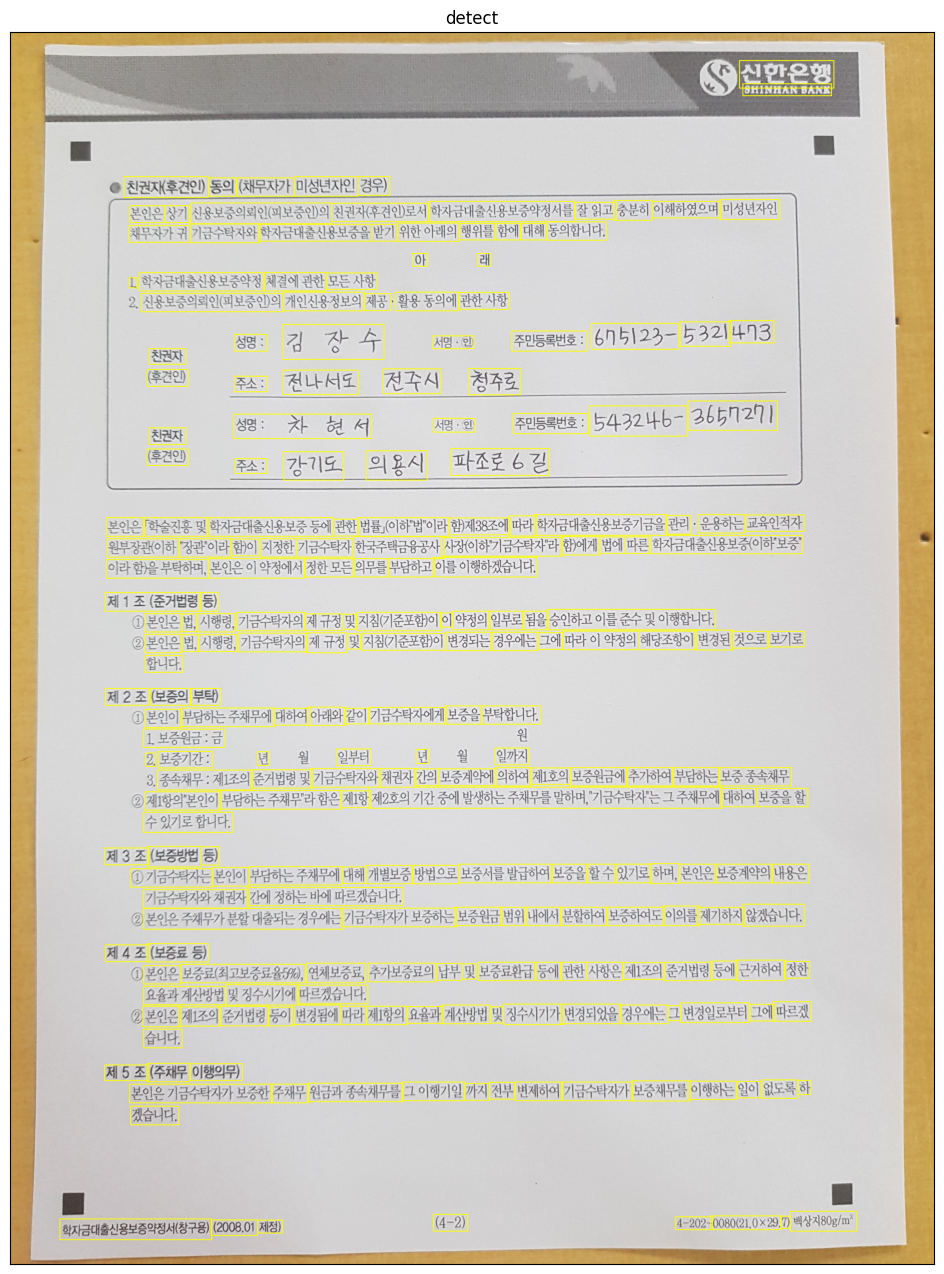

In [14]:
img_dir = 'doc_test_images'
file_list = [file for file in os.listdir(img_dir)]
img_path = os.path.join(img_dir, file_list[12])
img = cv2.imread(img_path)
img_cv_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

text_box_list, horizontal_list, free_list = reader.detect(img, 
                                         min_size = 20, text_threshold = 0.85,\
                                         low_text = 0.5, link_threshold = 0.2,\
                                         canvas_size = 2240, mag_ratio = 1.75,\
                                         slope_ths = 0.1, ycenter_ths = 0.4,\
                                         height_ths = 0.5, width_ths= 0.5,\
                                         add_margin = 0.1, reformat = False,\
                                         threshold = 0.2, bbox_min_score = 0.2,\
                                         bbox_min_size = 3, max_candidates = 0)

# get the 1st result from hor & free list as self.detect returns a list of depth 3
horizontal_list, free_list = horizontal_list[0], free_list[0]

bbox_list = []
maximum_y,maximum_x = img.shape[:2]
for box in horizontal_list:
    x_min = max(0,box[0])
    x_max = min(box[1],maximum_x)
    y_min = max(0,box[2])
    y_max = min(box[3],maximum_y)
    width = x_max - x_min
    height = y_max - y_min
    
    bbox_list.append([[x_min,y_min],[x_max,y_min],[x_max,y_max],[x_min,y_max]])
    

result_img = img.copy()
# loop over the results
for bbox in bbox_list:
    (tl, tr, br, bl) = bbox
    
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))

    # 추출한 영역에 사각형을 그리고 인식한 글자를 표기합니다.
    cv2.rectangle(result_img, tl, br, (0, 255, 255), 2)

plt_imshow(title='detect', img=result_img, figsize=(20,16))

# 검출 -> 인식 테스트

In [ ]:
text_box = text_box_list[0]

### group_text_box func.
horizontal_list, free_list,combined_list, merged_list = [],[],[],[]

slope_ths = 0.1
ycenter_ths = 0.4                                        
height_ths = 0.5 
width_ths= 0.5
add_margin = 0.1
sort_output = False

for i,poly in enumerate(text_box):
    slope_up = (poly[3]-poly[1])/np.maximum(10, (poly[2]-poly[0]))
    #print('slope_up: {}'.format(slope_up))
    slope_down = (poly[5]-poly[7])/np.maximum(10, (poly[4]-poly[6]))
    #print('slope_down: {}'.format(slope_up))
    if max(abs(slope_up), abs(slope_down)) < slope_ths:
        x_max = max([poly[0],poly[2],poly[4],poly[6]])
        x_min = min([poly[0],poly[2],poly[4],poly[6]])
        y_max = max([poly[1],poly[3],poly[5],poly[7]])
        y_min = min([poly[1],poly[3],poly[5],poly[7]])
        horizontal_list.append([x_min, x_max, y_min, y_max, 0.5*(y_min+y_max), y_max-y_min])
    else:
        height = np.linalg.norm([poly[6]-poly[0],poly[7]-poly[1]])
        width = np.linalg.norm([poly[2]-poly[0],poly[3]-poly[1]])

        margin = int(1.44*add_margin*min(width, height))

        theta13 = abs(np.arctan( (poly[1]-poly[5])/np.maximum(10, (poly[0]-poly[4]))))
        theta24 = abs(np.arctan( (poly[3]-poly[7])/np.maximum(10, (poly[2]-poly[6]))))
        # do I need to clip minimum, maximum value here?
        x1 = poly[0] - np.cos(theta13)*margin
        y1 = poly[1] - np.sin(theta13)*margin
        x2 = poly[2] + np.cos(theta24)*margin
        y2 = poly[3] - np.sin(theta24)*margin
        x3 = poly[4] + np.cos(theta13)*margin
        y3 = poly[5] + np.sin(theta13)*margin
        x4 = poly[6] - np.cos(theta24)*margin
        y4 = poly[7] + np.sin(theta24)*margin

        free_list.append([[x1,y1],[x2,y2],[x3,y3],[x4,y4]])
if sort_output:
    horizontal_list = sorted(horizontal_list, key=lambda item: item[4])



# combine box
new_box = []
combined_list = []

for poly in horizontal_list:
    if len(new_box) == 0:
        b_height = [poly[5]]
        b_ycenter = [poly[4]]
        new_box.append(poly)
    else:
        b_height = [poly[5]]
        b_ycenter = [poly[4]]
        combined_list.append(new_box)
        new_box = [poly]
combined_list.append(new_box)



# merge list use sort again
merged_list = []
for boxes in combined_list:
    box = boxes[0]
    margin = int(add_margin*min(box[1]-box[0],box[5]))
    merged_list.append([box[0]-margin,box[1]+margin,box[2]-margin,box[3]+margin])
    
    
horizontal_list = merged_list
horizontal_list_agg, free_list_agg = [], []
min_size = 20
if min_size:
    horizontal_list = [i for i in horizontal_list if max(
        i[1] - i[0], i[3] - i[2]) > min_size]
    free_list = [i for i in free_list if max(
        diff([c[0] for c in i]), diff([c[1] for c in i])) > min_size]
horizontal_list_agg.append(horizontal_list)
free_list_agg.append(free_list)

In [ ]:
horizontal_list

In [ ]:
horizontal_list, free_list = horizontal_list_agg[0], free_list_agg[0]
recog_result = reader.recognize(img_cv_grey, horizontal_list, free_list,\
                  decoder = 'greedy', beamWidth= 5, batch_size = 1,\
                  workers = 0, allowlist = None, blocklist = None, detail = 1,\
                  rotation_info = None,paragraph = False,\
                  contrast_ths = 0.1,adjust_contrast = 0.5, filter_ths = 0.003,\
                  y_ths = 0.5, x_ths = 1.0, reformat=True, output_format='standard')

result_img = img.copy()
text_img = np.ones(shape=img.shape, dtype=np.uint8) * 255

# loop over the results
for (bbox, text, prob) in recog_result:
    print("[INFO] {:.4f}: {}".format(prob, text))

    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))
    # 추출한 영역에 사각형을 그리고 인식한 글자를 표기합니다.
    cv2.rectangle(result_img, tl, br, (0, 255, 255), 2)
    text_img = put_text(text_img, text, tl[0], tl[1], 255, 30)
    #cv2.putText(business_card_image, text, (tl[0], tl[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

result_imgs = [result_img, text_img]
plt_imshow(title=['OCR Detection', 'OCR Recognition'], img=result_imgs, figsize=(20,16))

## 인식 결과 그룹핑 (인입 대상에 따라 안하는 게 더 나을 수 있음)

In [ ]:
bbox_list, text_list, score_list = [], [], []
for result in recog_result:
    bbox = result[0]
    text = result[1]
    score = result[2]
    bbox_list.append(bbox)
    text_list.append(text)
    score_list.append(score)
    


new_horizontal_list = []
for bbox in bbox_list:
    tl, tr, br, bl = bbox
    
    left, top = tl
    right, bottom = br
    
    ycenter = 0.5*(top+bottom)
    height = bottom-top
    
    new_horizontal_list.append([left, right, top, bottom, ycenter, height])
    
    
# combine box : 가까운 단어들 그룹핑
new_combined_list = []
new_box = []

combined_text_list = []
new_text = []
combined_score_list = []
new_score = []
ycenter_ths = 0.4
for i, poly in enumerate(new_horizontal_list):
    if len(new_box) == 0:
        b_height = [poly[5]]
        b_ycenter = [poly[4]]
        new_box.append(poly)
        new_text.append(text_list[i])
        new_score.append(score_list[i])
    else:
        # comparable height and comparable y_center level up to ths*height
        # combine 되는 애들
        if abs(np.mean(b_ycenter) - poly[4]) < ycenter_ths*np.mean(b_height):
            b_height.append(poly[5])
            b_ycenter.append(poly[4])
            new_box.append(poly)
            new_text.append(text_list[i])
            new_score.append(score_list[i])
        # 독자적인 애들
        else:
            b_height = [poly[5]]
            b_ycenter = [poly[4]]
            new_combined_list.append(new_box)
            new_box = [poly]
            combined_text_list.append(new_text)
            new_text = [text_list[i]]
            combined_score_list.append(new_score)
            new_score = [score_list[i]]
new_combined_list.append(new_box)
combined_text_list.append(new_text)
combined_score_list.append(new_score)

In [ ]:
result_img = img.copy()
text_img = np.ones(shape=img.shape, dtype=np.uint8) * 255

# loop over the results
for (bbox_list, text_list, prob_list) in zip(new_combined_list, combined_text_list, combined_score_list):
    print("[INFO] {}".format(text_list))
    text = ' '.join(text_list)
    print(text)
    for i, bbox in enumerate(bbox_list):
        print(bbox)
        if i == 0:
            ml = bbox[0]
            mt = bbox[2]
            mr = bbox[1]
            mb = bbox[3]
            continue
        
        if bbox[0] < ml:
            ml = bbox[0]
        if bbox[2] < mt:
            mt = bbox[2]
        if bbox[1] > mr:
            mr = bbox[1]
        if bbox[3] > mb:
            mb = bbox[3]
    
    # 추출한 영역에 사각형을 그리고 인식한 글자를 표기합니다.
    cv2.rectangle(result_img, (ml, mt), (mr, mb), (0, 255, 255), 2)
    text_img = put_text(text_img, text, ml, mt, 255, 34)
    #cv2.putText(business_card_image, text, (tl[0], tl[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

result_imgs = [result_img, text_img]
plt_imshow(title=['OCR Detection', 'grouping after recognition'], img=result_imgs, figsize=(18,12))

In [ ]:
import albumentations as A

In [ ]:
noise_img = A.GaussNoise(var_limit=(3000.0, 3000.0), p=1)(image=img)['image']

In [ ]:
blur_img = A.GaussianBlur(blur_limit=(19, 19), p=1)(image=img)['image']

In [ ]:
plt_imshow(img=blur_img, figsize=(20,16))

In [ ]:
plt_imshow(img=noise_img, figsize=(20,16))

In [ ]:
import torch
torch.cuda.device_count()

In [ ]:
gpu = torch.cuda.current_device()
gpu

In [ ]:
torch.cuda.device_count() // 2